In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.switch_backend('agg')
import json
import glob
import itertools
import os

# functions

In [2]:
def load_json_as_df(pathdir, sub, feature, run, hemi, roi):
    df = pd.DataFrame(columns=['node', 'correlation', 'hemi','roi','features', 'run' ])
    fname = 'corrcoef_{0}_model-visual_align-ws_feature-{1}_foldshifted-{2}_hemi-{3}_range-{4}.json'.format(sub, feature, run, hemi, roi)
    fullpath = os.path.join(pathdir, fname)
    if os.path.exists(fullpath):
        with open(fullpath) as f:
            corr = json.load(f)
        df = pd.DataFrame(corr)
        column_indices = [0, 1]
        new_names = ['node','correlation']
        old_names = df.columns[column_indices]
        df.rename(columns=dict(zip(old_names, new_names)), inplace=True)
        df['features'] = feature
        df['roi'] = roi
        df['hemi'] = hemi
        df['run'] = run
    return df

In [3]:
def isListEmpty(inList):
    if isinstance(inList, list): # Is a list
        return all( map(isListEmpty, inList) )
    return False # Not a list


# load data

('sub: ', 'sub-rid000005')
('roi: ', 'ips', ' hemi: ', 'lh')
('ind: ', 0)


AttributeError: 'NoneType' object has no attribute 'remove'

<Figure size 432x288 with 0 Axes>

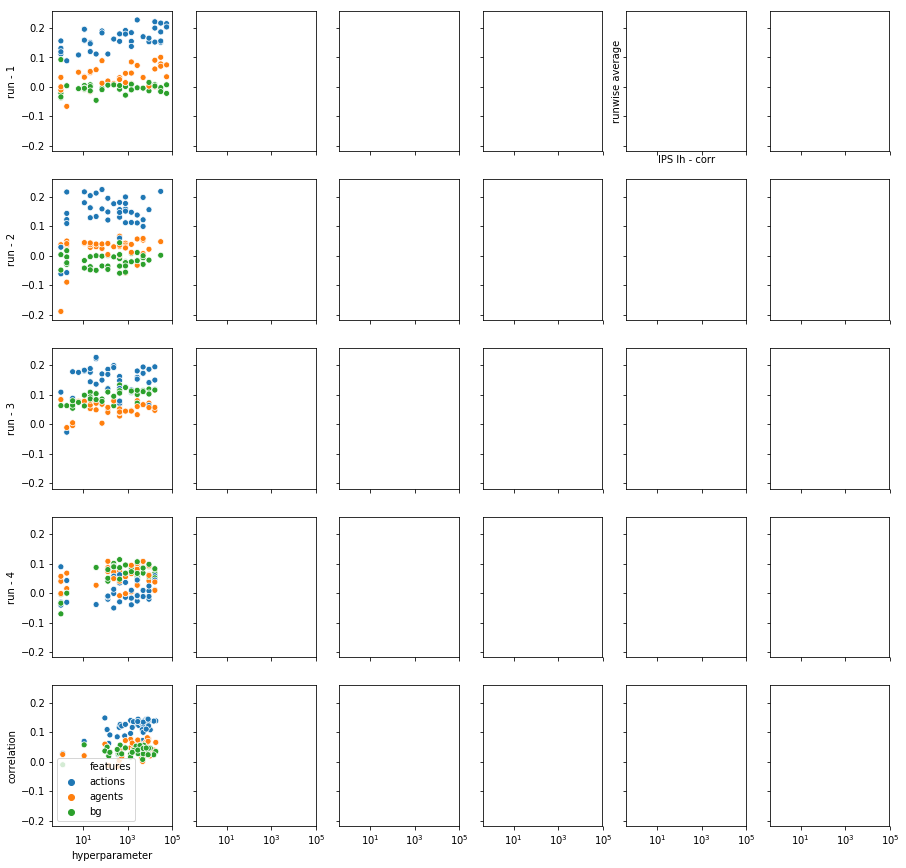

In [6]:
sub_list = [  'sub-rid000005', 'sub-rid000006', 'sub-rid000009',  'sub-rid000017',  'sub-rid000027','sub-rid000033',  'sub-rid000037', 'sub-rid000005', 'sub-rid000012', 'sub-rid000019', 'sub-rid000031', 'sub-rid000034',  'sub-rid000038', 'sub-rid000006', 'sub-rid000014',  'sub-rid000024', 'sub-rid000032',  'sub-rid000036',  'sub-rid000041'] #'sub-rid000001',
a = [['ips', 'loc', 'vt'], ['lh', 'rh']]
b = list(itertools.product(*a))



for sub in sub_list:
    print("sub: ", sub)
    plt.figure()
    # plt.ion()
    ind = 0
    fig, axes = plt.subplots( 5,6, figsize=(15, 15),  sharey=True, sharex = True)
    for  roi, hemi in b:
        print("roi: ", roi, " hemi: ", hemi)
        print("ind: ", ind)
        roiwise_df = []
        # average_run = pd.DataFrame([])
        # pd.DataFrame(columns = ['node', 'correlation', 'hyperparameter', 'run'])
        for run in range(1,5):
            # print("run", run)
            df_merged = None
            # df_merged = None
            # load df and stack for every run and every feature
            hyperp_dir = os.path.join('/dartfs/rc/lab/D/DBIC/DBIC/f0042x1/life-encoding/results/PCA_tikreg-loro_fullrange-10000-ROI/ws/visual/bg_actions_agents/', 'leftout_run_{0}'.format(run), sub, hemi)
            hyper_bname = 'hyperparam-alpha_{0}_model-visual_align-ws_foldshifted-{1}_hemi-{2}_range-{3}.json'.format(sub, run, hemi, roi)
            hyper_fname = os.path.join(hyperp_dir, hyper_bname)

            if os.path.exists(hyper_fname):
                # info = os.path.basename(hyper_fname).split("_")
                with open(hyper_fname) as h:
                    hyper = json.load(h)
                hyper_df = pd.DataFrame(hyper)

                column_indices = [0, 1]
                new_names = ['node','hyperparameter']
                old_names = hyper_df.columns[column_indices]
                hyper_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

                action_df = load_json_as_df(hyperp_dir, sub, 'actions', run, hemi, roi)
                agents_df = load_json_as_df(hyperp_dir, sub, 'agents', run, hemi, roi)
                bg_df = load_json_as_df(hyperp_dir, sub, 'bg', run, hemi, roi)
                stack_df = pd.concat([action_df, agents_df, bg_df])
                df_merged = stack_df.merge(hyper_df, on=["node"])
                df_merged['run'] = run
                roiwise_df.append(df_merged)
                sns.scatterplot(ax=axes[run-1, ind], x="hyperparameter", y= "correlation",
                        hue="features",
                        data=df_merged);
                axes[run-1, ind].set_ylabel('run - {0}'.format(run))
                axes[run-1, ind].set_xscale('log')
                axes[run-1, ind].set_xlabel(str('{0} {1}'.format(roi.upper(), hemi)))
                axes[run-1, ind].get_legend().remove()

            else:
                # ind += 1
                df_merged = []
                roiwise_df.append(df_merged)
                continue
        # print(roiwise_df)
        if isListEmpty(roiwise_df):
            ind += 1
            continue
        else:
            # print("Not Empty list!")
            concat_df = pd.concat(roiwise_df)
            A = concat_df.groupby([ 'features','node'])[['correlation', 'hyperparameter']].mean()
            # print(A)
            sns.scatterplot(ax=axes[ 4, ind], x=A.hyperparameter, y= A.correlation, hue=A.index.get_level_values("features"),
            data = A); 
            axes[ind,4].set_ylabel('runwise average')
            axes[ind,4].set_xscale('log')
            axes[ind,4].set_xlabel(str('{0} {1} - corr'.format(roi.upper(), hemi)))
            axes[ind,4].get_legend().remove()
            ind += 1
            # continue
        # 
        # roiwise_df = pd.concat(roiwise_df)
    # axes.show()
    save_dir = os.path.join('/dartfs/rc/lab/D/DBIC/DBIC/f0042x1/life-encoding/results/PCA_tikreg-loro_fullrange-10000-ROI/ws/visual/bg_actions_agents/')
    handles, labels = axes[ ind,4].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=3)

    fig.suptitle('{0} - hyperparam & correlation per roi/run'.format(sub))
    # fig.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=3)
    # fig.tight_layout()
    plt.savefig(os.path.join(save_dir, "hyperNcorr_{0}_T.png".format(sub)))
    # g.figure.savefig(os.path.join(save_dir, "hyperNcorr_{0}.png".format(sub)))
    # axes.clear()
            # plot per run and feature
            #average across runs
            # plot average run per feature
